# Diagnostics
When working with a McStas instrument it is possible to record what is happening not only at the detector, but along the entire instrument. It is tempting to add many monitors along the instrument to investigate all this for every run of the instrument, but this can result in confusing instrument output with many monitors where only few are important.

McStasScript has a diagnostics tool that allows inserting monitors temporarily to understand the instrument, and in this way they do not pollute the results of every run. For our examples we will need an example instrument, so here we have a source with a guide that contains a velocity selector followed by a monochromator and sample.

In [1]:
import mcstasscript as ms

instr = ms.McStas_instr("demo_instr")

# McStas 2.X
instr.add_declare_var("double", "x_at_source")
instr.add_declare_var("double", "x_after_guide")
# McStas 3.X
#instr.add_user_var("double", "x_at_source")
#instr.add_user_var("double", "x_after_guide")

wavelength = instr.add_parameter("wavelength", value=5.0, comment="Wavelength for mono in [AA]")
w_min = instr.add_parameter("w_min", value=3, comment="Minimum wavelength from source[AA]")
w_max = instr.add_parameter("w_max", value=6, comment="Maximum wavelength from source[AA]")

src = instr.add_component("Source", "Source_simple")
src.set_parameters(xwidth=0.1, yheight=0.1, focus_xw=0.04, focus_yh=0.06, dist=2, flux=1E7)
src.lambda0 = "(w_max+w_min)/2"
src.dlambda = "(w_max-w_min)/2"
src.append_EXTEND("x_at_source=x;")
src.append_EXTEND("x_after_guide=0;")

guide1 = instr.add_component("guide1", "Guide_gravity")
guide1.set_parameters(w1=src.focus_xw, h1=src.focus_yh,
                     m=2, G=-9.82, l=10)
guide1.set_AT(src.dist, RELATIVE=src)

v_sel = instr.add_component("V_sel", "V_selector")
v_sel.set_parameters(xwidth=guide1.w1, yheight=guide1.h1, zdepth=0.4,
                     radius=0.15, length=0.3, nu=370)
v_sel.set_AT(guide1.l + 0.5*v_sel.zdepth + 1E-6, RELATIVE=guide1)

guide2 = instr.add_component("guide2", "Guide_gravity")
guide2.set_parameters(w1=src.focus_xw, h1=src.focus_yh,
                     m=2, G=-9.82, l=15)
guide2.set_AT(0.5*v_sel.zdepth + 0.01, RELATIVE=v_sel)
guide2.set_ROTATED([0, 0.7, 0], RELATIVE=v_sel)

guide3 = instr.add_component("guide3", "Guide_gravity")
guide3.set_parameters(w1=guide2.w1, h1=guide2.h1,
                     w2=guide2.w1*0.8, h2=guide2.h1*0.8,
                     m=2, G=-9.82, l=10)
guide3.set_AT(guide2.l + 0.01, RELATIVE=guide2)
guide3.set_ROTATED([0, 0.7, 0], RELATIVE=guide2)
guide3.append_EXTEND("x_after_guide = x;")

mono_Q = instr.add_declare_var("double", "mono_Q", value=1.714) # Q for Ge 311
instr.add_declare_var("double", "wavevector")
instr.append_initialize("wavevector = 2.0*PI/wavelength;")

mono_rotation = instr.add_declare_var("double", "mono_rotation")
instr.append_initialize("mono_rotation = asin(mono_Q/(2.0*wavevector))*RAD2DEG;")
instr.append_initialize('printf("monochromator rotation = %g deg\\n", mono_rotation);')

mono = instr.add_component("mono", "Monochromator_flat")
mono.zwidth = 0.05
mono.yheight = 0.08
mono.Q = mono_Q
mono.set_AT(guide3.l + 0.3, RELATIVE=guide3)
mono.set_ROTATED([0, mono_rotation, 0], RELATIVE=guide3)

beam_direction = instr.add_component("beam_dir", "Arm", AT_RELATIVE=mono)
beam_direction.set_ROTATED([0, mono_rotation, 0], RELATIVE=mono)

slit = instr.add_component("slit", "Slit")
slit.radius = 0.03
slit.set_AT(0.6, RELATIVE=beam_direction)

sample = instr.add_component("sample", "PowderN")
sample.set_AT(0.1, RELATIVE=slit)
sample.radius = 0.015
sample.yheight = 0.05
sample.reflections = '"Na2Ca3Al2F14.laz"'

banana = instr.add_component("banana", "Monitor_nD", RELATIVE=sample)
banana.xwidth = 1.2
banana.yheight = 0.3
banana.restore_neutron = 1
banana.filename = '"banana.dat"'
banana.options = '"theta limits=[20 175] bins=150, banana"'

Lam = instr.add_component("Lam", "L_monitor")
Lam.nL = 160
Lam.filename = '"Lambda.dat"'
Lam.xwidth = 0.05
Lam.yheight = 0.05
Lam.Lmin = "wavelength*0.3"
Lam.Lmax = "wavelength*1.7"
Lam.restore_neutron = 1
Lam.set_AT([0, 0, 0.1], RELATIVE=sample)

## Diagram in analysis mode
One important aspect of a McStas simulation is how the intensity and number of rays evolves over the course of the instrument. To investigate this, analysis can be enabled in the diagram.

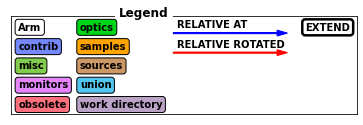

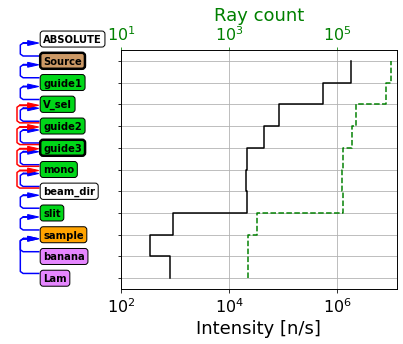

In [2]:
instr.show_diagram(analysis=True)

Such a graph shows the intensity measured just before each component in the instrument. There are some circumstances that can be difficult to interpret correctly, for example here we see the intensity and number of rays rise after the banana detector, how can this be? This is because the banana detector is placed at the sample position, inside the sample, and some rays are already past that point and are thus not recorded.


## Analyzing a variable
Furthermore one can investigate any variable from the table below with the variable keyword.

| Axis string | Full name | Unit | Description |
| --- | --- | --- | --- |
| t | time | s | Particle time |
| x | x position | m | Coordinate x of particle |
| y | y position | m | Coordinate y of particle |
| z | z position | m | Coordinate z of particle |
| vx | x velocity | m/s | Velocity projected onto x |
| vy | y velocity | m/s | Velocity projected onto y |
| vz | z velocity | m/s | Velocity projected onto z |
| p | weight | intensity | Particle weight McStas n/s |
| l | lambda | AA | Particle wavelength |
| e | energy | meV | Particle energy |
| speed | speed | m/s | Speed (length of velocity vector) |
| dx | x divergence | deg | Divergence from z axis along x axis |
| dy | y divergence | deg | Divergence from z axis along y axis |

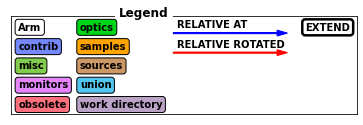

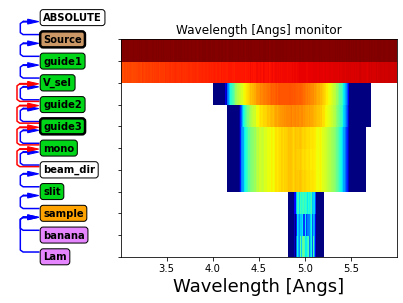

In [3]:
instr.show_diagram(variable="l")

Above we see the wavelength distribution along the instrument.
- Before guide1: Uniform distribution from source
- After guide1: Some transmission losses, especially at lower wavelength
- After V_sel: Chooses a limited wavelength range
- After guide2 and guide3: further transmission losses
- After mono: No change (neutrons are either transmitted or scattered)
- After slit: Only rays scattered by mononchromator continue

This tool is useful for quickly understanding what is going on in an instrument. Below we set up a situation where the wavelength selected by the monochromator is on the edge of what is transmitted by the velocity selector. The limit keyword can be used to zoom into an important area of the plot.

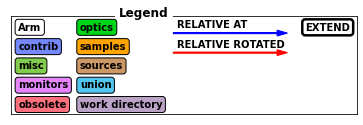

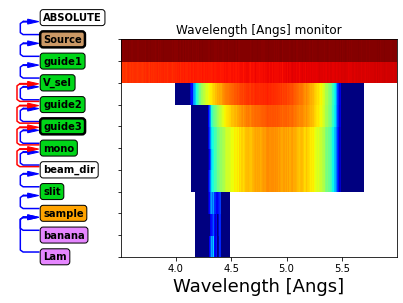

In [4]:
instr.set_parameters(wavelength=4.3, w_min=1, w_max=6)
instr.show_diagram(variable="l", limits=[3.5, 6])

## Beam analysis
In addition to an overview of the instrument, McStasScript can view detailed beam characteristics at user selected points along the instrument. In order to access these features, the user has to create a diagnostics object from the instrument.

In [5]:
diag = ms.Diagnostics(instr)

The diagnostics object contains a copy of the instrument as it was when the diagnostics object was created, so if the instrument is updated, a new diagnostics object should be made. The diagnostics object will also take a copy of the parameters and settings of the instrument, but these can be modified with the usual methods, without impacting the original instrument.

In [6]:
diag.settings(ncount=1E7, suppress_output=True)
diag.show_settings()

Instrument settings:
  ncount:           1.00e+07
  output_path:      demo_instr_data
  run_path:         .
  package_path:     /Users/madsbertelsen/McStas/McCode/install/mcstas/3.9999-git
  executable_path:  /Users/madsbertelsen/McStas/McCode/install/mcstas/3.9999-git/bin/
  executable:       mcrun
  force_compile:    True


In [7]:
diag.set_parameters(wavelength=5, w_min=4, w_max=6)
diag.show_parameters()

 wavelength  = 5  // Wavelength for mono in [AA]
 w_min       = 4  // Minimum wavelength from source[AA]
 w_max       = 6  // Maximum wavelength from source[AA]


The diagnostics object can hold two additional kinds of information that will help with diagnostics, *points* and *views*. 

### Diagnostics points
The *points* are points in the instrument where the beam is analyzed. Such a point is given as either *before* or *after* a component in the instrument.

If one inserts a point *before* a component, the beam will be analyzed by a flat monitor at the position of the component, this monitor will be before the chosen component in the instrument component sequence. The particles are restored, so it is as if the monitor was not there at all.

Selecting *after* would place the monitor after the chosen component in the component sequence, and the monitor will record the particles as they leave the chosen component.

In both cases the monitor will record events at those points, and as default it will record 50000 rays. This can be changed with the *rays* keyword argument. Notice that the full intensity will not be shown in these diagnostics results as only part of the rays are recorded to save drive space, but it is possible to set rays to "all" if full intensities are required, at the cost of some large data files especially at higher ncounts.

We add some points to the diagnostics object with the *add_point* method. We start by focusing on the guide system.

In [8]:
diag.clear_points()
diag.add_point(before="guide1")
diag.add_point(after="V_sel")
diag.add_point(after="guide3")

diag.show_points()

Diagnostics point before: guide1                    - rays: 50000
Diagnostics point after:  V_sel                     - rays: 50000
Diagnostics point after:  guide3                    - rays: 50000


It is possible to remove points with the *remove_point* method, it uses the same syntax. It is also possible to clear all points with *clear_points*.

User variables or flags in the instrument can be included in the event information recorded at each point, to tell the diagnostics object which of these should be recorded, use the *add_flag* method. A maximum of three flags can be investigated and the current flags can be cleared with *clear_flags*.

In [9]:
diag.clear_flags()
diag.add_flag("x_at_source")
diag.add_flag("x_after_guide")
print(diag)

Instrument diagnostics for: demo_instr
Diagnostics points: 
  Diagnostics point before: guide1                    - rays: 50000
  Diagnostics point after:  V_sel                     - rays: 50000
  Diagnostics point after:  guide3                    - rays: 50000
Views: 
  No views yet
Recording following user variables:
  x_at_source
  x_after_guide
Does not yet contain simulated data


### Running diagnostics
We can now run the diagnostics instrument using the run method. This will insert the monitors at the requested positions within the instrument and perform a simulation with the current settings and parameters. It can now be seen in the print of the diagnostics object that it contains simulated data, and the number of rays recorded at each point. 

In [10]:
diag.run()
print(diag)


loading system configuration
INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/demo_instr_data_10"
INFO: Regenerating c-file: demo_instr.c
CFLAGS=
      
 The parameter format of sample is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./demo_instr.out
./demo_instr.c:7212:123: warning: format specifies type 'long' but the argument has type 'unsigned long long' [-Wformat]
            { printf("Monitor_nD: %s cannot reallocate Vars->Mon2D_Buffer[%li] (%li). Skipping.\n", Vars->compcurname, i,

### Views
Since the data recorded at the points is event data, we can choose how to view this data after the simulation. This is done by adding *views*.

All views need to define at least one axis the events should be binned into, and can optionally choose a second for a 2D histogram. The axis keyword takes all the same inputs as the variable for diagrams and any flags defined.

Here we define a few views and plot the information. The plot will contain all views at all points, but remember they only record up to the number of specified rays, so the intensities are not accurate.

In [11]:
diag.clear_views()

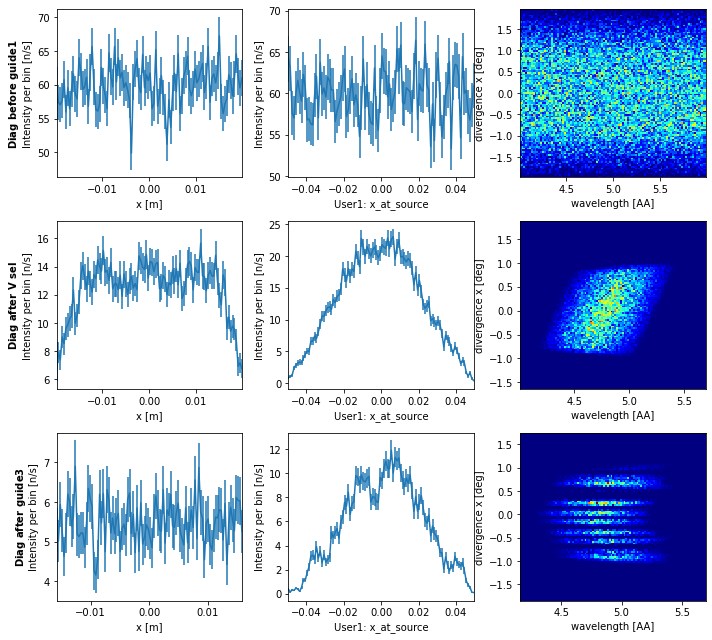

In [12]:
diag.clear_views()
diag.add_view("x")
diag.add_view("x_at_source")
diag.add_view("l", "dx")

diag.plot()

From this data we see the spatial distribution before the first guide element is uniform as expected.

When we look at the beam after the velocity selector we see a slightly narrower spatial distribution, and can see that rays that make it to this point were most likely to be from the center of the source. We also see the velocity selector limits the wavelength range as expected, but also introduces some correlation between wavelength and divergence due to the direction of rotation.

After the last guide element we see the final beam, it is homogeneous spatially, but there are issues with the divergence distribution and a surprising correlation with the wavelength. The gaps in divergence arise from the compression by the guide which is done in a problematic way.

### View keyword arguments
Views have two keyword arguments that can alter how they behave, and in addition to these they can take all keyword arguments *set_plot_options* would allow.

| Keyword | Default | Description |
| --- | --- | --- |
| same_scale | False | Ensures all views are plotted on the same scale |
| bins | 100 | Number of bins, for 2D plot can be a list of 2, one for each axis |

Below we demonstrate how the same scale keyword argument changes a view.

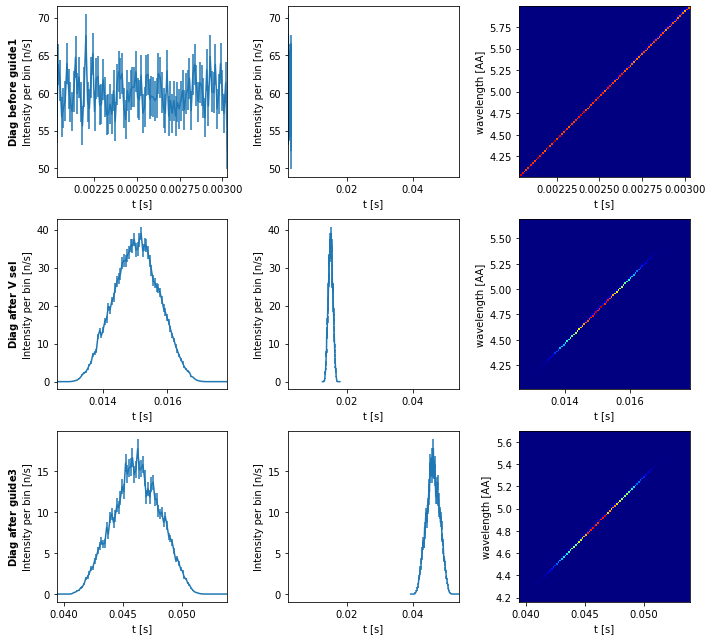

In [13]:
diag.clear_views()
diag.add_view("t")
diag.add_view("t", same_scale=True)
diag.add_view("t", "l")

diag.plot()

Without *same_scale* enabled we see the tof distribution at each point, while the one with *same_scale* enabled draws attention to how the distribution widens as the beam propagates.

We can now analyze the backend of the instrument by defining a new range of points.

In [14]:
diag.clear_points()
diag.add_point(after="guide3")
diag.add_point(after="mono", rays=8E4)
diag.add_point(before="sample", rays=8E4)
diag.add_point(after="sample", rays=8E4)

diag.settings(ncount=3E7)
diag.run()


loading system configuration
INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/demo_instr_data_11"
INFO: Regenerating c-file: demo_instr.c
CFLAGS=
      
 The parameter format of sample is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./demo_instr.out
./demo_instr.c:9179:123: warning: format specifies type 'long' but the argument has type 'unsigned long long' [-Wformat]
            { printf("Monitor_nD: %s cannot reallocate Vars->Mon2D_Buffer[%li] (%li). Skipping.\n", Vars->compcurname, i,

In [15]:
print(diag)

Instrument diagnostics for: demo_instr
Diagnostics points: 
  Diagnostics point after:  guide3                    - rays: 50000 / 50000
  Diagnostics point after:  mono                      - rays: 80000 / 80000
  Diagnostics point before: sample                    - rays: 80000 / 80000
  Diagnostics point after:  sample                    - rays: 80000 / 80000
Views: 
  View (t)                  bins: 100
  View (t)                  bins: 100
  View (t, l)               bins: 100
Recording following user variables:
  x_at_source
  x_after_guide
Does contain simulated data


We set up a new list of views to investigate the backend of the instrument.

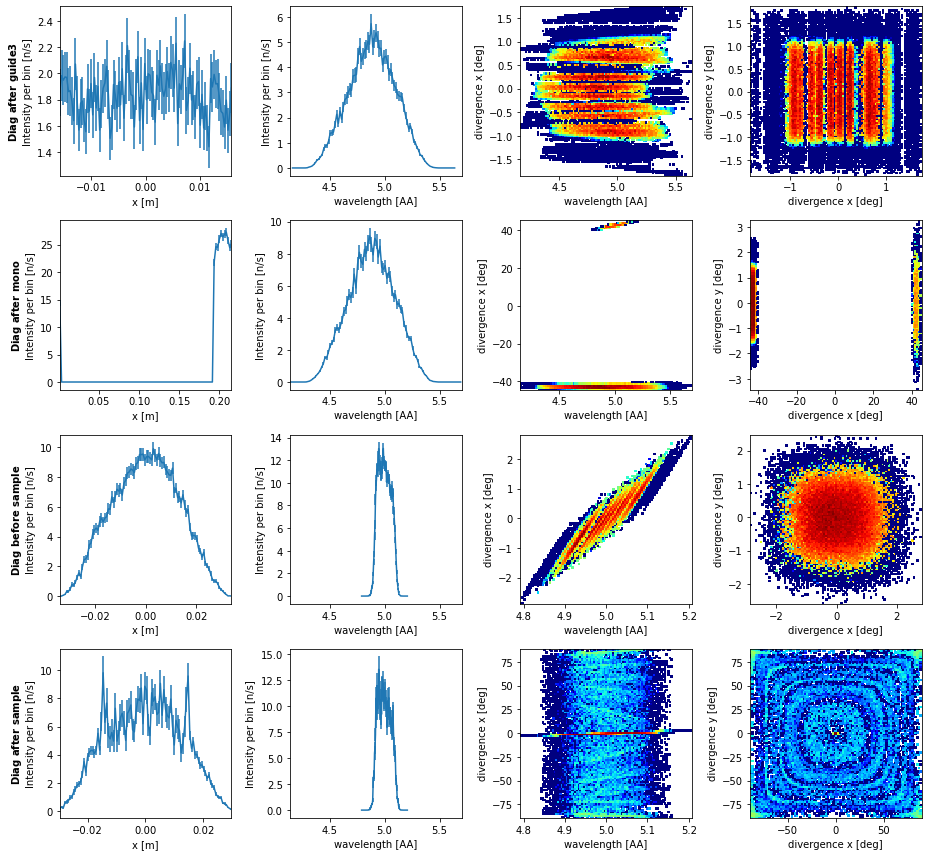

In [16]:
diag.clear_views()

diag.add_view("x")
diag.add_view("l", same_scale=True)
diag.add_view("l", "dx", log=True, orders_of_mag=4.5)
diag.add_view("dx", "dy", log=True, orders_of_mag=6)

diag.plot()

From this data we see the expected distributions after the guide which we already considered. The data after the monochromator is however unexpected. This is because it shows both rays that scattered on the monochromator and rays that didn't, those that did are near x=0 while those that did not are near x=0.2, which is the exit of the guide in the rotated coordinate system of the monochromator. The remaining views after the monochromator shows that the total wavelength distribution is unchanged, but now a its divided into the direct beam at -42 deg, and the scattered beam at 42 deg.
Before the sample we see the wavelength distribution reduced to that which made it through the slit, so the transmitted beam is no longer included.
After the sample we see how the center of the beam was attenuated and the Debye-Scherrer rings can be seen in both 2D plots.

The diagnostics system can be used to investigate many interesting aspects of the instrument, here we will look at one final aspect using the defined user variables that record position at the source and after the guide, as we can look at the correlations between the two. When looking at such data over the different points in the instrument, only events that made it to that point is included, so the correlation may change slightly.

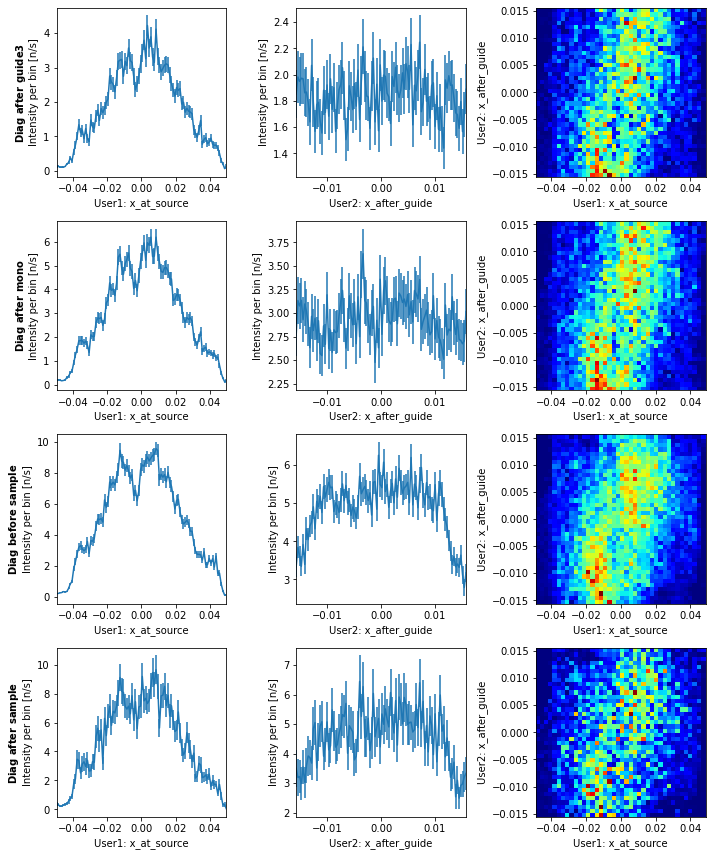

In [17]:
diag.clear_views()
diag.add_view("x_at_source")
diag.add_view("x_after_guide")
diag.add_view("x_at_source", "x_after_guide", bins=[40, 40])

diag.plot()

Here we see that if the ray originated at the positive x side of the source, it is also likely to be on the positive x side after the guide. Mainly the center 4 cm of the source is used in this configuration of the instrument, which could change depending on wavelength and coating of the guide.